Prior to this, the raw data has been parsed through the data_clean notebook. In that notebook, irregularities in the dataset have been removed which were consequences of the scraping, and 3 columns have been added, namely Province, which was derived from the Location, and using a dataset of all towns in the Netherlands, the province was found, Make, which was derived from the title and a dataset of all well-known car makes, and models, which was also derived from the title in a similar manner.

In this file, we will further explore the data, remove outliers, and try to learn as much about the data as possible.

Let's import the needed libraries and change the settings

In [25]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Reading in the main cleaned dataframe. The body column was very sparse, so we discarded it altogether.

In [26]:
df = pd.read_csv('data/cleaned/data_NoNaN.csv')
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
1,volkswagen,golf,6499,2010.00,206344.00,Almere,Flevoland,Autoservice Almere,volkswagen golf 1.2 tsi highl. bluem | pdc v+a...
2,volkswagen,golf,11950,2015.00,145000.00,'s-Gravenhage,Zuid-Holland,M.B.,volkswagen golf 1.2 tsi lounge 5d 2015 grijs -...
3,ford,fusion,5900,2010.00,53973.00,Amsterdam,Noord-Holland,Micho,ford fusion mpv 2010 1.4 16v zwart lage km 53k
4,ford,focus,10500,2008.00,142000.00,Hoeven,Noord-Brabant,Armin,ford focus st 2.5 turbo 270pk leer recaro inte...
...,...,...,...,...,...,...,...,...,...
4247,volkswagen,h1,21800,2018.00,148087.00,Heel Nederland,In every province,Action Lease,volkswagen transporter l1 h1 2018 €306 per maand
4248,renault,h1,24700,2021.00,67051.00,Heel Nederland,In every province,Action Lease,renault trafic l2 h1 2021 €344 per maand
4249,renault,h1,41800,2022.00,60.00,Heel Nederland,In every province,Action Lease,renault master l3 h1 2022 €635 per maand
4250,volkswagen,h2,17600,2017.00,198504.00,Heel Nederland,In every province,Action Lease,volkswagen crafter l2 h2 2017 €247 per maand


Let's take a deeper look at the price column.

In [27]:
pd.options.display.float_format = '{:.2f}'.format
df["Price"].describe()

count      4252.00
mean      24276.38
std      110446.03
min           0.00
25%        7950.00
50%       16800.00
75%       27900.00
max     5749999.00
Name: Price, dtype: float64

As we can see below cars with a listing price more than 150k only make up 0.4% of all listings, there are also major outliers, like cars worth millions. For the sake of this project, we will discard these very high value cars.

In [28]:
count = 0
for price in df["Price"]:
    if price > 150000:
        count += 1
total = len(df["Price"])
percentage = count / total *100
number = len(df["Price"]) * (percentage /100)
percentage, number

(0.37629350893697083, 16.0)

Let's remove all cars below 500 and above 150000 euros.

In [29]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


df = remove_outliers(df, 'Price', lower=500, upper=150001)
df = df.drop_duplicates()

In [30]:
df["Price"].describe()


count     2999.00
mean     21779.05
std      18809.92
min        505.00
25%       8900.00
50%      17450.00
75%      28700.00
max     149999.00
Name: Price, dtype: float64

Let's continue by looking at the price distribuion of all car listings.

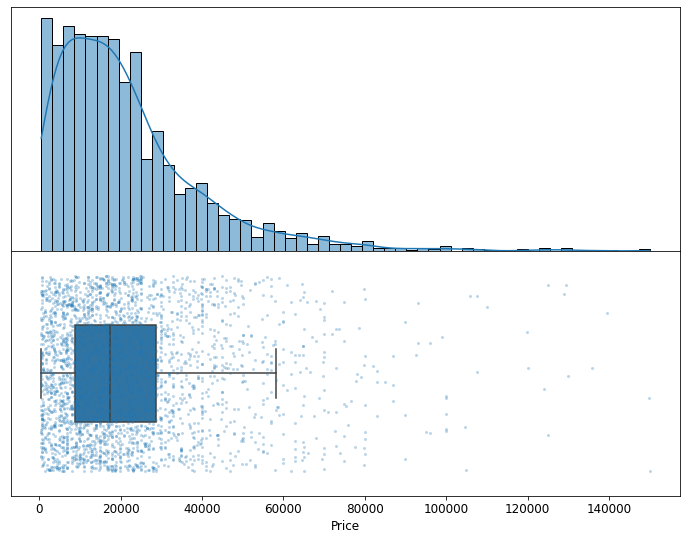

In [31]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

A potential outlier is the lowest price bin. In the collection of the data, we attempted to collect private and company listings seperately, marktplaats, however, did not do a very good job at that. We loaded the dataframe as a whole, meaning that we have both private and company listings in the dataframe. The low price  listings are very likely lease options, in which we are not interested.
Let's take a look.

In [32]:
df.loc[df.Price<1000]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
100,porsche,cayenne,626,2012.00,162865.00,Veenendaal,Utrecht,ROS finance,porsche cayenne 4.8 gts | sport chrono | leder...
101,audi,q5,879,2020.00,32765.00,Veenendaal,Utrecht,ROS finance,audi q5 55 tfsi e 367pk 20inch 3x s-line lucht...
109,mercedes,200,621,2018.00,39945.00,Veenendaal,Utrecht,ROS finance,mercedes-benz a-klasse 200 *amg edition 1* pan...
200,mercedes,h2,608,2021.00,62453.00,Veenendaal,Utrecht,ROS finance,mercedes-benz sprinter 317 cdi l2 h2 mbux / 36...
205,audi,e-tron,916,2022.00,9105.00,Veenendaal,Utrecht,ROS finance,"audi q4 sportback e-tron 35 s-line 52 kwh 20"" ..."
...,...,...,...,...,...,...,...,...,...
2833,bmw,x4,703,2017.00,77904.00,Veenendaal,Utrecht,ROS finance,bmw x4 xdrive28i high executive m sport editio...
2841,mercedes,2,634,2015.00,94245.00,Veenendaal,Utrecht,ROS finance,mercedes-benz v-klasse cdi amg 190pk lang dc 2...
2842,mercedes,gt,532,2015.00,129124.00,Veenendaal,Utrecht,ROS finance,mercedes-benz vito 119 cdi amg gt 225 pk aut d...
2921,volkswagen,fox,850,2006.00,220516.00,Amersfoort,Utrecht,Autohandel Honing,volkswagen fox 1.2 trendline


Looking at the table above shows that many of these cars are leases. This can be seen by the fact that the seller name and title contain the word lease, and also by the fact that cars under 1000 should mostly be low value old cars, not a 2012 4.8 Porsche Cayenne :).

We can try to remove lease options by first of all looking at which titles and sellers contain the words lease, finance, etc.
We could also make an argument for a correlation between Year and price, and decide that cars built after a certain year should not be less than 1000 euros.
Let's remove all listings in which the Title or the Seller contain the words lease or finance

In [33]:
df = df[~df.Title.str.contains('lease|finance', case=False)]
df = df[~df.Seller.str.contains('lease|finance', case=False)]
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
1,volkswagen,golf,6499,2010.00,206344.00,Almere,Flevoland,Autoservice Almere,volkswagen golf 1.2 tsi highl. bluem | pdc v+a...
2,volkswagen,golf,11950,2015.00,145000.00,'s-Gravenhage,Zuid-Holland,M.B.,volkswagen golf 1.2 tsi lounge 5d 2015 grijs -...
3,ford,fusion,5900,2010.00,53973.00,Amsterdam,Noord-Holland,Micho,ford fusion mpv 2010 1.4 16v zwart lage km 53k
4,ford,focus,10500,2008.00,142000.00,Hoeven,Noord-Brabant,Armin,ford focus st 2.5 turbo 270pk leer recaro inte...
...,...,...,...,...,...,...,...,...,...
2972,mercedes,h2,28900,2019.00,103413.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h2 l2 diesel 2019 wit
2976,ford,h1,24900,2019.00,61148.00,Barneveld,Gelderland,Dutchvans.com,ford transit h1 l4 diesel 2019 wit
2984,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
2985,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


That removed quite some rows! Let's look at the price distribution again.

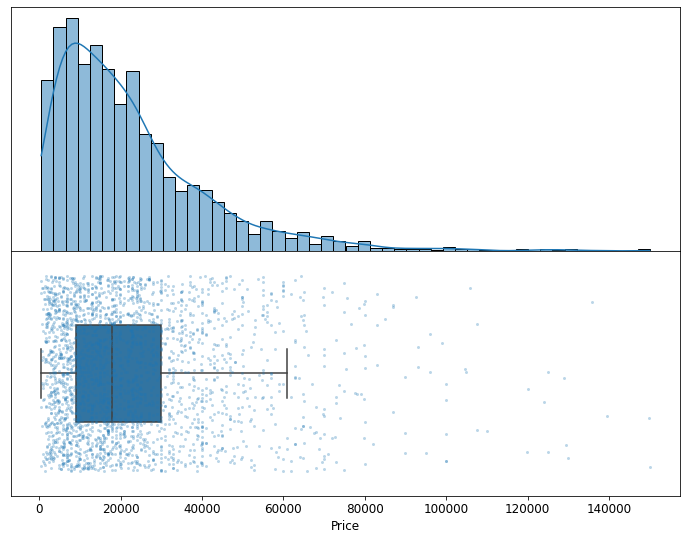

In [34]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"],
    orient='h',
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

This distribution makes much more sense. Now let's look at the distribution and listing prices of cars per province and how many cars are sold in each province.

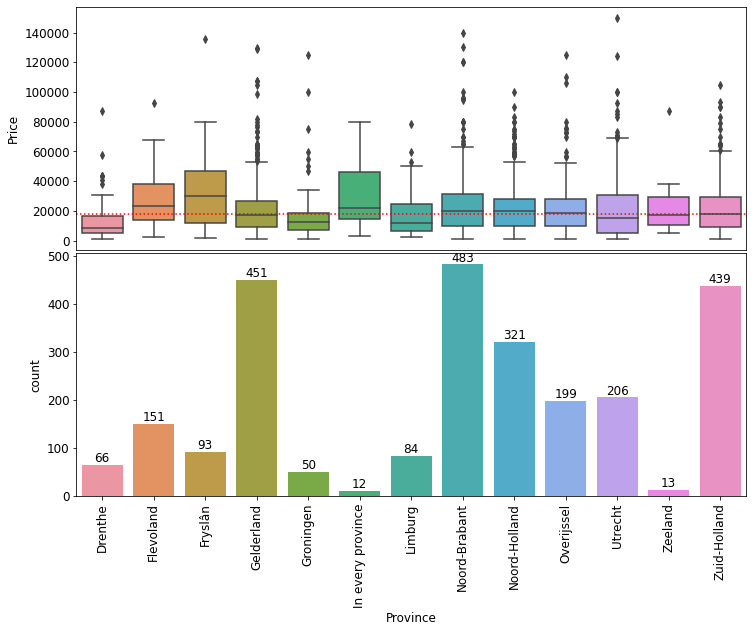

In [49]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Province',
    y='Price',
    data=df.sort_values('Province'),
    ax=axs[0]
)

sns.countplot(
    x='Province',
    data=df.sort_values('Province'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=df['Price'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

Now we can see that the mean listing price the cars are pretty close to each other for all of the provinces, but we do however see large difference in the amount of listings per province. But this is probably because most of these provinces are in the Randstad where much more people live as opposed to provinces such as Limburg, Zeeland, and Drenthe for example.
Now let's also look at the correlation between the Year the car was built and the Price.

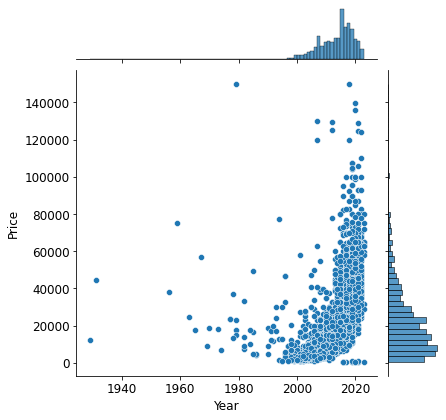

In [35]:
sns.jointplot(x='Year', y='Price', data=df)

We are removing cars before the year of 1995, as they cause much noise but are relatively sparse. They are noisy because some old cars have high value because of their old age, while othersare simply old and unreliable and therefore have the opposite effect. This is difficult to predict, and adds more noise that it does good.

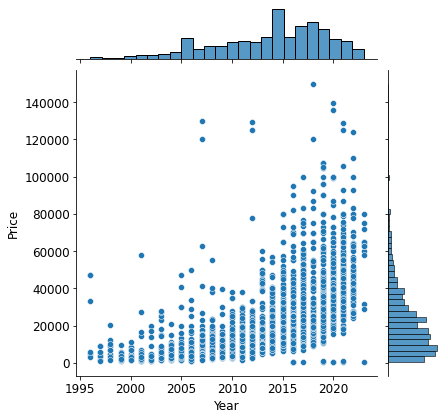

In [36]:
df = df[df.Year>1995]
sns.jointplot(x='Year', y='Price', data=df)

In this plot we can see that, from from 2005 to 2015, no cars are in the lowest price bracket. However, from 2015 to current, that bracket is populated again. Let's try removing all cars that are built from 2014 onwards, but are listed at a price lower than 1000 euros. These are very likely lease options.

In [37]:
df[(df.Year>=2013) & (df.Price<=1000)]

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
504,renault,m3,520,2023.00,150.00,Arnhem,Gelderland,Vissinga Automotive B.V.,renault master 10x bakwagen met 1000 kg laadkl...
1732,audi,sq5,699,2017.00,146967.00,Haarlem,Noord-Holland,Auto Krediet Plan,audi sq5 3.0 tfsi quattro abt 385pk performanc...
1752,audi,q7,529,2016.00,193202.00,Haarlem,Noord-Holland,Auto Krediet Plan,audi q7 3.0 tdi e-tron quattro s-line black op...
1753,audi,q7,579,2016.00,122710.00,Haarlem,Noord-Holland,Auto Krediet Plan,audi q7 3.0 tdi e-tron quattro s competition- ...
1754,audi,a7,549,2016.00,37431.00,Haarlem,Noord-Holland,Auto Krediet Plan,audi a7 sportback 1.8 tfsi s-line competition ...
1819,volkswagen,golf,649,2021.00,30351.00,Haarlem,Noord-Holland,Auto Krediet Plan,volkswagen golf 1.5 etsi r performance aut- ha...
1827,mercedes,gla,799,2021.00,12764.00,Haarlem,Noord-Holland,Auto Krediet Plan,mercedes-benz gla 250 4-matic amg night editio...
1828,mercedes,200,729,2019.00,72774.00,Haarlem,Noord-Holland,Auto Krediet Plan,mercedes-benz cla-klasse 200 amg night edition...
1831,mercedes,200,649,2020.00,49361.00,Haarlem,Noord-Holland,Auto Krediet Plan,mercedes-benz cla-klasse 200 amg night edition...
1835,mercedes,gle,999,2019.00,25968.00,Haarlem,Noord-Holland,Auto Krediet Plan,mercedes-benz gle 300 d 4matic amg night editi...


<AxesSubplot:xlabel='Year', ylabel='Price'>

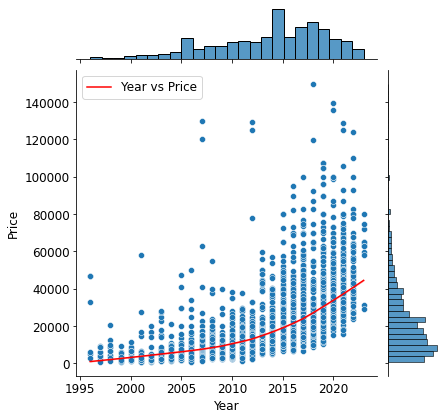

In [38]:
df = df[(df.Year<=2013) | (df.Price>=1000)]
sns.jointplot(x='Year', y='Price', data=df)
xobs = df.Year
yobs = df.Price
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Year vs Price', color='red')

Let's take a look at the correlation between the mileage of the car versus the price. We see a clear trend, where cars with less mileage are more expensive.

<AxesSubplot:xlabel='Price', ylabel='Ran'>

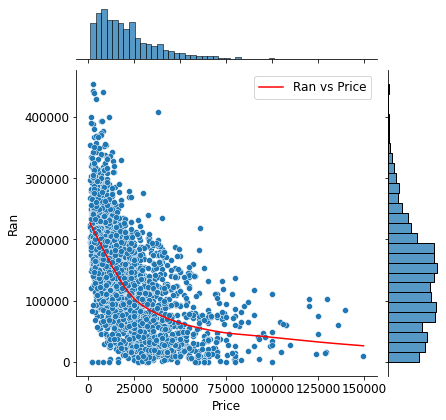

In [39]:
sns.jointplot(x='Price', y='Ran', data=df)
xobs = df.Price
yobs = df.Ran
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Ran vs Price', color='red')

Regressing based on year and mileage is interesting, however, a 2018 audi with 100.000 km is not the same price as a 2018 hyundai.
In the preprocessing, we have added makes and models of each vehicle. Let's see what information we can get from this!

In [40]:
df

,Make,Model,Price,Year,Ran,Location,Province,Seller,Title
0,audi,a3,11000,2013.00,201500.00,Lent,Gelderland,Jeroen,audi a3 s-line sportback facelift 2013 wit
1,volkswagen,golf,6499,2010.00,206344.00,Almere,Flevoland,Autoservice Almere,volkswagen golf 1.2 tsi highl. bluem | pdc v+a...
2,volkswagen,golf,11950,2015.00,145000.00,'s-Gravenhage,Zuid-Holland,M.B.,volkswagen golf 1.2 tsi lounge 5d 2015 grijs -...
3,ford,fusion,5900,2010.00,53973.00,Amsterdam,Noord-Holland,Micho,ford fusion mpv 2010 1.4 16v zwart lage km 53k
4,ford,focus,10500,2008.00,142000.00,Hoeven,Noord-Brabant,Armin,ford focus st 2.5 turbo 270pk leer recaro inte...
...,...,...,...,...,...,...,...,...,...
2645,mercedes,h2,28900,2019.00,103413.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h2 l2 diesel 2019 wit
2646,ford,h1,24900,2019.00,61148.00,Barneveld,Gelderland,Dutchvans.com,ford transit h1 l4 diesel 2019 wit
2647,volkswagen,h1,14600,2012.00,183398.00,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
2648,mercedes,h1,19300,2018.00,226713.00,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


In [41]:
df_makes = df[['Make', 'Price', 'Ran', 'Year']].groupby(by='Make').agg({'Price':'mean', 'Year':'mean','Ran':'mean'})

In [46]:
df_makes['Make'] = df_makes.index
df_makes

,Price,Year,Ran,Make
Make,,,,
aixam,11172.50,2017.25,34672.25,aixam
alfa romeo,33735.00,2013.60,109934.30,alfa romeo
audi,28942.01,2014.28,141123.70,audi
bentley,46968.00,2003.20,106578.20,bentley
bmw,31593.08,2013.97,134543.54,bmw
cadillac,44950.00,2015.00,92100.00,cadillac
chevrolet,18820.50,2009.71,142778.00,chevrolet
chrysler,4286.25,2005.00,236297.25,chrysler
citroen,6043.78,2010.22,137847.00,citroen


<AxesSubplot:xlabel='Make', ylabel='Price'>

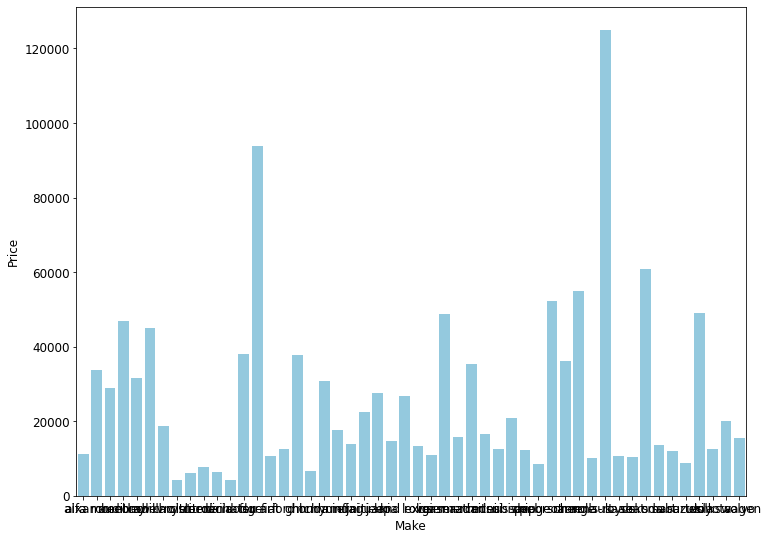

In [43]:
sns.barplot(x='Make', y='Price', data=df_makes, color='skyblue')

While this visualization is not very interpretable, it does tell us that there is a lot of variation in the means of the prices of specific makes. It was likely a good choice to sacrifice some data to add the makes as a feature.

In [44]:
df.Model.value_counts()

golf       342
a3         111
tiguan      92
cooper      77
200         72
          ... 
matrix       1
phaeton      1
eclipse      1
aura         1
hr-v         1
Name: Model, Length: 215, dtype: int64

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# define the categorical features to be one-hot encoded
categorical_features = ['Make', 'Model']

# define the numerical features
numerical_features = ['Ran', 'Year']

# preprocess the categorical features using one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[categorical_features + numerical_features], df['Price'], test_size=0.2, random_state=0)

# fit the preprocessor on the training data
preprocessor.fit(X_train)

# transform the categorical features on both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# get the feature names for the one-hot encoded categorical features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# combine the one-hot encoded categorical features and numerical features
X_train_processed = pd.concat([pd.DataFrame(X_train_encoded.toarray(), columns=cat_feature_names), X_train[numerical_features].reset_index(drop=True)], axis=1)
X_test_processed = pd.concat([pd.DataFrame(X_test_encoded.toarray(), columns=cat_feature_names), X_test[numerical_features].reset_index(drop=True)], axis=1)

# train a linear regression model
reg = LinearRegression().fit(X_train_processed, y_train)

# make predictions on the test set
y_pred = reg.predict(X_test_processed)

# evaluate the model performance
r2 = r2_score(y_test, y_pred)
print('R-squared score:', r2)


R-squared score: -28730744803.271385
